In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from theano import tensor as tt
import scipy.stats as st
import seaborn as sns
import scipy
import import_ipynb
import GP_util #load module first
import importlib
importlib.reload(GP_util) # reload full module
from GP_util import unique, select, fastdistancematrix,linear_pixel
#import methods from reloaded module

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


importing Jupyter notebook from GP_util.ipynb
importing Jupyter notebook from GP_util.ipynb


In [131]:
datapath = '/home/brian/WesternWheat/Data/Processed/maxdf_24.csv'
df = pd.read_csv(datapath)

df = select(df, n=3000) # selects subset of df for time/memory reductions

In [132]:
f, df_unique, zero_farm_idx, Num_farms = unique(df)

there are 2050 unique farms in loaded df


In [133]:
distance, Dmatsq = fastdistancematrix(df, distance_calc=True)

In [16]:
with pm.Model() as GP_true:
    
    # ======  prior function   ========
    # ====== covariance matrix ========
    # ======        K          ========
    etasq = pm.Gamma('etasq', 5,10) # sets maximum covariance ij
    l = pm.Gamma('l', alpha = 3, beta=.01)
    sigmay = 1e-2
    Kij = etasq*(np.exp(-Dmatsq/l**2)+np.diag([sigmay]*Num_farms))
    
 
    # ========== gaussian process informing prior slope covariance ========
    w = pm.MvNormal('w', mu=np.zeros(Num_farms), cov=Kij, shape=Num_farms) # prior slopes to be trained
    a = pm.Normal('a', 0, .5, shape=Num_farms) # prior intercep
   
    # ========== Linear Model =============== 
    u = pm.Deterministic('mu',a[zero_farm_idx]  + w[zero_farm_idx]*df.zprsum3)
    #============ Likelihood ==============
    #sigma = pm.Uniform('sigma', 0,2)
    #sigma = pm.HalfCauchy('sigma',)
    sigma = pm.Gamma('sigma',5,10)
    y = pm.Normal('y', mu=u, sd=sigma, observed=df.zNDVIsum3) 

    trace = pm.sample(1000,tune=100,chains=2)


/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/model.py:1266: UserWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [y_missing, sigma, a, w, l, etasq]
Sampling 2 chains: 100%|██████████| 2200/2200 [08:00<00:00,  4.51draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [38]:
with pm.Model() as GP_true:

    # ====== covariance matrix ========
    etasq = pm.Gamma('etasq', 3,6) # sets maximum covariance ij
    #etasq = pm.HalfCauchy('etasq',.7)
    lsq = pm.Gamma('lsq', alpha = 3.5, beta=1.2e-5)
    #l = pm.HalfCauchy('l', 100)
    #rhosq = pm.Uniform('rhosq',lower=0,upper=1e-5)
    sigmay = 1e-1
    Kij = etasq*(np.exp(-Dmatsq/lsq)+np.diag([sigmay]*Num_farms))
    #K = np.nan_to_num(Kij) + 1e-1 #no nans allowed
 
    # ========== gaussian process informing prior slope covariance ========
    w = pm.MvNormal('w', mu=np.zeros(Num_farms), cov=Kij, shape=Num_farms) # prior slopes to be trained
    a = pm.Normal('a', 0, .5, shape=Num_farms) # prior intercep
    #a = np.zeros(Num_farms)
    # ========== Linear Model =============== 
    u = pm.Deterministic('mu',a[zero_farm_idx]  + w[zero_farm_idx]*df.zprsum3)
    #============ Likelihood ==============
    #sigma = pm.Uniform('sigma', 0,2)
    #sigma = pm.HalfCauchy('sigma',)
    sigma = pm.Gamma('sigma',5,10)
    y = pm.Normal('y', mu=u, sd=sigma, observed=df.zNDVIsum3) 

    trace_lsq = pm.sample(1000,tune=100,chains=2)


/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/model.py:1266: UserWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [y_missing, sigma, a, w, lsq, etasq]
Sampling 2 chains: 100%|██████████| 2200/2200 [05:36<00:00,  5.36draws/s]
The acceptance probability does not match the target. It is 0.9010556400446182, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


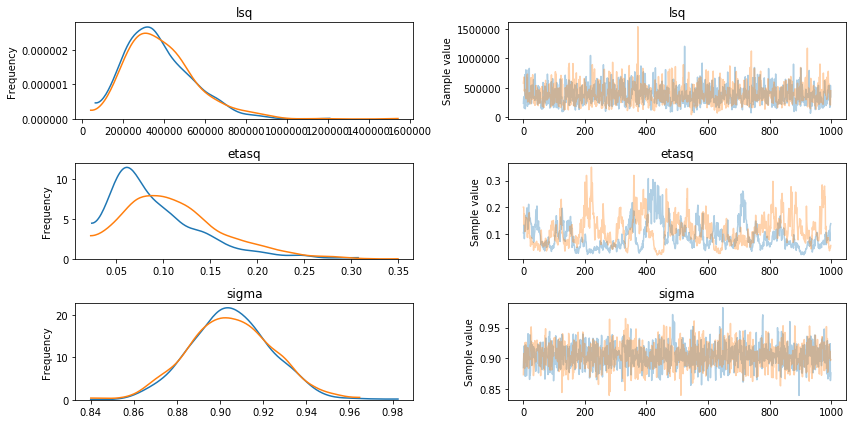

In [39]:
pm.traceplot(trace_lsq, varnames=['lsq','etasq','sigma']);

In [40]:
pm.summary(trace_lsq,varnames=['sigma','lsq','etasq'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma,0.904791,0.019061,0.000504,0.867396,0.940828,1534.895247,0.999560
lsq,379587.629461,164211.482354,4540.131535,96987.180379,693846.328159,1219.531967,1.001744
etasq,0.103934,0.052880,0.004217,0.024194,0.208121,55.891474,1.036423


In [153]:
with pm.Model() as GP_uncentered:
    # to "uncenter":
    #to sample from MvN(0,K) multiply L z where LL^T = K
    # and z = N(0,1) the scale parameter of in this case the normal dist

    # ============== kernel ===============
    etasq = .3 # pm.Gamma('etasq', 5,10) # sets maximum covariance ij
    lsq = 5e5 #pm.Gamma('lsq', alpha = 5, beta=7e-5)
    #ls = pm.Deterministic('l', tt.sqrt(lsq))
    sigmay = .01
    Kij = etasq*(np.exp(-Dmatsq/lsq)+np.diag([sigmay]*Num_farms))
    
    
    # ========== kernel informing prior slope covariance ========
    z = pm.Normal('z', 0., 1., shape=Num_farms) # scale parameter
    w = pm.Deterministic('w', tt.dot(tt.slinalg.cholesky(Kij), z)) # prior slope

    a = pm.Normal('a', 0, .3, shape=Num_farms) # prior intercep
    
    # ========== Linear Model =============== 
    u = pm.Deterministic('mu',a[zero_farm_idx]  
                         + w[zero_farm_idx]*df.zprsum3) 
                         
    
    #============ Likelihood ==============
    sigma = pm.Gamma('sigma',5,10)
    #sigma = .5
    y = pm.Normal('y', mu=u, sd=sigma, observed=df.zNDVIsum3) 
    
    # ============ sample =================
    trace_pr = pm.sample(1000,chains=2) #nuts_kwargs={'target_accept': .95}

500000.0

In [344]:
trace_2000_prvpd = {5e5: trace_lsq,1e5:trace_prvpd,4e4:trace_prvpd2,1e4:trace_prvpd3,
             'm0':GP_uncentered,'m1':GP_uncentered_prvpd,'m2':GP_uncentered_prvpd2,
                   'm3':GP_uncentered_prvpd3}

trace_2000_prvpd

{500000.0: <MultiTrace: 2 chains, 1000 iterations, 9 variables>,
 100000.0: <MultiTrace: 2 chains, 1000 iterations, 9 variables>,
 40000.0: <MultiTrace: 2 chains, 1000 iterations, 9 variables>,
 10000.0: <MultiTrace: 2 chains, 1000 iterations, 9 variables>,
 'm0': <pymc3.model.Model at 0x7f1997f3d358>,
 'm1': <pymc3.model.Model at 0x7f193951b898>,
 'm2': <pymc3.model.Model at 0x7f1939299fd0>,
 'm3': <pymc3.model.Model at 0x7f1939cb9a20>}

In [350]:
with pm.Model() as GP_uncentered:
    # to "uncenter":
    #to sample from MvN(0,K) multiply L z where LL^T = K
    # and z = N(0,1) the scale parameter of in this case the normal dist

    # ============== kernel ===============
    etasq = .3 # pm.Gamma('etasq', 5,10) # sets maximum covariance ij
    lsq = 5e5 #pm.Gamma('lsq', alpha = 5, beta=7e-5)
    #ls = pm.Deterministic('l', tt.sqrt(lsq))
    sigmay = .01
    Kij = etasq*(np.exp(-Dmatsq/lsq)+np.diag([sigmay]*Num_farms))
    
    
    # ========== kernel informing prior slope covariance ========
    z = pm.Normal('z', 0., 1., shape=Num_farms) # scale parameter
    w = pm.Deterministic('w', tt.dot(tt.slinalg.cholesky(Kij), z)) # prior slope
    zvpd = pm.Normal('zvpd', 0., 1., shape=Num_farms) # scale parameter
    w1 = pm.Deterministic('w1', tt.dot(tt.slinalg.cholesky(Kij), zvpd))
    a = pm.Normal('a', 0, .3, shape=Num_farms) # prior intercep
    
    # ========== Linear Model =============== 
    u = pm.Deterministic('mu',a[zero_farm_idx]  
                         + w[zero_farm_idx]*df.zprsum3 
                         + w1[zero_farm_idx]*df.zvpdmean3)
    
    #============ Likelihood ==============
    sigma = pm.Gamma('sigma',5,10)
    #sigma = .5
    y = pm.Normal('y', mu=u, sd=sigma, observed=df.zNDVIsum3) 
    
    # ============ sample =================
    #trace_prvpd = pm.sample(1000,chains=2) #nuts_kwargs={'target_accept': .95}
    
    
    
with pm.Model() as GP_uncentered_prvpd:
    # to "uncenter":
    #to sample from MvN(0,K) multiply L z where LL^T = K
    # and z = N(0,1) the scale parameter of in this case the normal dist

    # ============== kernel ===============
    etasq = 1 # pm.Gamma('etasq', 5,10) # sets maximum covariance ij
    lsq = 1e5 #pm.Gamma('lsq', alpha = 5, beta=7e-5)
    #ls = pm.Deterministic('l', tt.sqrt(lsq))
    sigmay = .01
    Kij = etasq*(np.exp(-Dmatsq/lsq)+np.diag([sigmay]*Num_farms))
    
    
    # ========== kernel informing prior slope covariance ========
    z = pm.Normal('z', 0., 1., shape=Num_farms) # scale parameter
    w = pm.Deterministic('w', tt.dot(tt.slinalg.cholesky(Kij), z)) # prior slope
    zvpd = pm.Normal('zvpd', 0., 1., shape=Num_farms) # scale parameter
    w1 = pm.Deterministic('w1', tt.dot(tt.slinalg.cholesky(Kij), zvpd))
    a = pm.Normal('a', 0, .3, shape=Num_farms) # prior intercep
    
    # ========== Linear Model =============== 
    u = pm.Deterministic('mu',a[zero_farm_idx]  
                         + w[zero_farm_idx]*df.zprsum3 
                         + w1[zero_farm_idx]*df.zvpdmean3)
    
    #============ Likelihood ==============
    sigma = pm.Gamma('sigma',5,10)
    #sigma = .5
    y = pm.Normal('y', mu=u, sd=sigma, observed=df.zNDVIsum3) 
    
    # ============ sample =================
    #trace_prvpd = pm.sample(1000,chains=2) #nuts_kwargs={'target_accept': .95}
    
with pm.Model() as GP_uncentered_prvpd2:
    # to "uncenter":
    #to sample from MvN(0,K) multiply L z where LL^T = K
    # and z = N(0,1) the scale parameter of in this case the normal dist

    # ============== kernel ===============
    etasq = 1 # pm.Gamma('etasq', 5,10) # sets maximum covariance ij
    lsq = 4e4 #pm.Gamma('lsq', alpha = 5, beta=7e-5)
    #ls = pm.Deterministic('l', tt.sqrt(lsq))
    sigmay = .01
    Kij = etasq*(np.exp(-Dmatsq/lsq)+np.diag([sigmay]*Num_farms))
    
    
    # ========== kernel informing prior slope covariance ========
    z = pm.Normal('z', 0., 1., shape=Num_farms) # scale parameter
    w = pm.Deterministic('w', tt.dot(tt.slinalg.cholesky(Kij), z)) # prior slope
    zvpd = pm.Normal('zvpd', 0., 1., shape=Num_farms) # scale parameter
    w1 = pm.Deterministic('w1', tt.dot(tt.slinalg.cholesky(Kij), zvpd))
    a = pm.Normal('a', 0, .3, shape=Num_farms) # prior intercep
    
    # ========== Linear Model =============== 
    u = pm.Deterministic('mu',a[zero_farm_idx]  
                         + w[zero_farm_idx]*df.zprsum3 
                         + w1[zero_farm_idx]*df.zvpdmean3)
    
    #============ Likelihood ==============
    sigma = pm.Gamma('sigma',5,10)
    #sigma = .5
    y = pm.Normal('y', mu=u, sd=sigma, observed=df.zNDVIsum3) 
    
    # ============ sample =================
    #trace_prvpd2 = pm.sample(1000,chains=2) #nuts_kwargs={'target_accept': .95}
    
    
    


/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/model.py:1266: UserWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/model.py:1266: UserWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/model.py:1266: UserWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)


In [286]:
with pm.Model() as GP_uncentered_prvpd3:
    # to "uncenter":
    #to sample from MvN(0,K) multiply L z where LL^T = K
    # and z = N(0,1) the scale parameter of in this case the normal dist

    # ============== kernel ===============
    etasq = 1 # pm.Gamma('etasq', 5,10) # sets maximum covariance ij
    lsq = 1e4 #pm.Gamma('lsq', alpha = 5, beta=7e-5)
    #ls = pm.Deterministic('l', tt.sqrt(lsq))
    sigmay = .01
    Kij = etasq*(np.exp(-Dmatsq/lsq)+np.diag([sigmay]*Num_farms))
    
    
    # ========== kernel informing prior slope covariance ========
    z = pm.Normal('z', 0., 1., shape=Num_farms) # scale parameter
    w = pm.Deterministic('w', tt.dot(tt.slinalg.cholesky(Kij), z)) # prior slope
    zvpd = pm.Normal('zvpd', 0., 1., shape=Num_farms) # scale parameter
    w1 = pm.Deterministic('w1', tt.dot(tt.slinalg.cholesky(Kij), zvpd))
    a = pm.Normal('a', 0, .3, shape=Num_farms) # prior intercep
    
    # ========== Linear Model =============== 
    u = pm.Deterministic('mu',a[zero_farm_idx]  
                         + w[zero_farm_idx]*df.zprsum3 
                         + w1[zero_farm_idx]*df.zvpdmean3)
    
    #============ Likelihood ==============
    sigma = pm.Gamma('sigma',5,10)
    #sigma = .5
    y = pm.Normal('y', mu=u, sd=sigma, observed=df.zNDVIsum3) 
    
    # ============ sample =================
    #trace_prvpd3 = pm.sample(1000,chains=2)

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/model.py:1266: UserWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [y_missing, sigma, a, zvpd, z]
Sampling 2 chains: 100%|██████████| 3000/3000 [41:15<00:00,  1.10draws/s] 


In [351]:
comp_df = pm.compare({GP_uncentered:trace_lsq,GP_uncentered_prvpd:trace_prvpd,
                     GP_uncentered_prvpd2:trace_prvpd2,GP_uncentered_prvpd3:trace_prvpd3});

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/brian/anaconda2/envs/py36/lib/python3.6/site-pack

In [288]:
comp_df

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
2,34914.9,1149.35,0,0,138.37,0,1
0,34923.6,926.09,8.72,0.54,139.02,24.14,1
1,34926.3,1123.3,11.44,0,138.21,11.82,1
3,34938.2,1228.19,23.34,0.46,138.28,18.57,1


In [352]:
comp_df

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
2,34914.9,1149.35,0,0,138.37,0,1
0,34923.6,926.09,8.72,0.54,139.02,24.14,1
1,34926.3,1123.3,11.44,0,138.21,11.82,1
3,34938.2,1228.19,23.34,0.46,138.28,18.57,1


In [353]:
comp_loo= pm.compare({GP_uncentered:trace_lsq,GP_uncentered_prvpd:trace_prvpd,
                     GP_uncentered_prvpd2:trace_prvpd2,GP_uncentered_prvpd3:trace_prvpd3},ic='LOO');
comp_loo

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:299: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")
/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:299: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen w

,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
0,34934.4,931.48,0,0.59,139.12,0,1
2,34942.3,1163.08,7.98,0,138.59,24.26,1
1,34951.2,1135.74,16.83,0,138.43,18.15,1
3,34977.5,1247.84,43.14,0.41,138.59,32.85,1


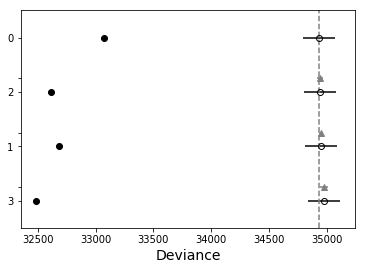

In [354]:
pm.compareplot(comp_loo);

In [319]:
#dlsq = pd.DataFrame(pm.summary(trace_lsq,varnames=['lsq','etasq']))
#d = pd.DataFrame(pm.summary(trace_prvpd, varnames=['sigma']))
traces = [trace_lsq,trace_prvpd,trace_prvpd2,trace_prvpd3]
for i in traces:
    print (pm.summary(i,varnames=['sigma']))

           mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff      Rhat
sigma  0.883927  0.005509  0.000081  0.873765  0.894831  6268.734746  0.999555
           mean       sd  mc_error   hpd_2.5  hpd_97.5       n_eff      Rhat
sigma  0.876303  0.00554  0.000111  0.865828  0.887887  2723.01951  0.999576
           mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff      Rhat
sigma  0.874904  0.005639  0.000129  0.863934  0.886248  2153.974838  0.999574
           mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff      Rhat
sigma  0.872476  0.005671  0.000114  0.861643  0.883719  2891.127498  0.999926


In [ ]:
# the smaller I set sigma too, the smaller lsq gets
# also lower n_eff for both eta and ls

In [264]:

#pm.traceplot(trace_lsq,combined=True)#,priors=[lsq.distribution, etasq.distribution], 
             #combined = True);

In [244]:
pm.stats.waic(trace_lsq, GP_uncentered)

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=34923.59414378378, WAIC_se=139.0189222930681, p_WAIC=926.0871250046023, var_warn=1)

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 's'
  s)


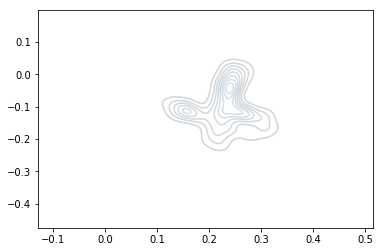

In [263]:
sns.kdeplot(trace_lsq['w'].mean(axis=0), trace_lsq['w1'].mean(axis=0), s=2, alpha=.2);

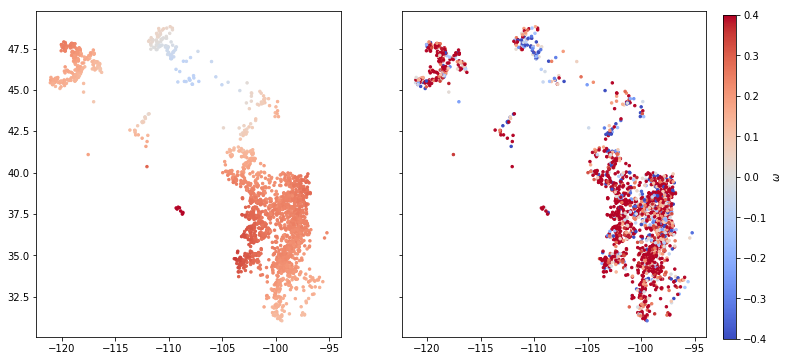

In [188]:
v = .4
fig, ax = plt.subplots(1,2, sharey=True, figsize=(12,6))
im = ax[0].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_lsq['w'].mean(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
ax[1].scatter(df_unique.Longitude,df_unique.Latitude,c=df_unique.B_zprsum3,
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
cax = plt.axes([.92, 0.12, 0.015, 0.75])
plt.colorbar(im,cax=cax,label=r'$\omega$');

In [281]:
plt.subplots?


/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


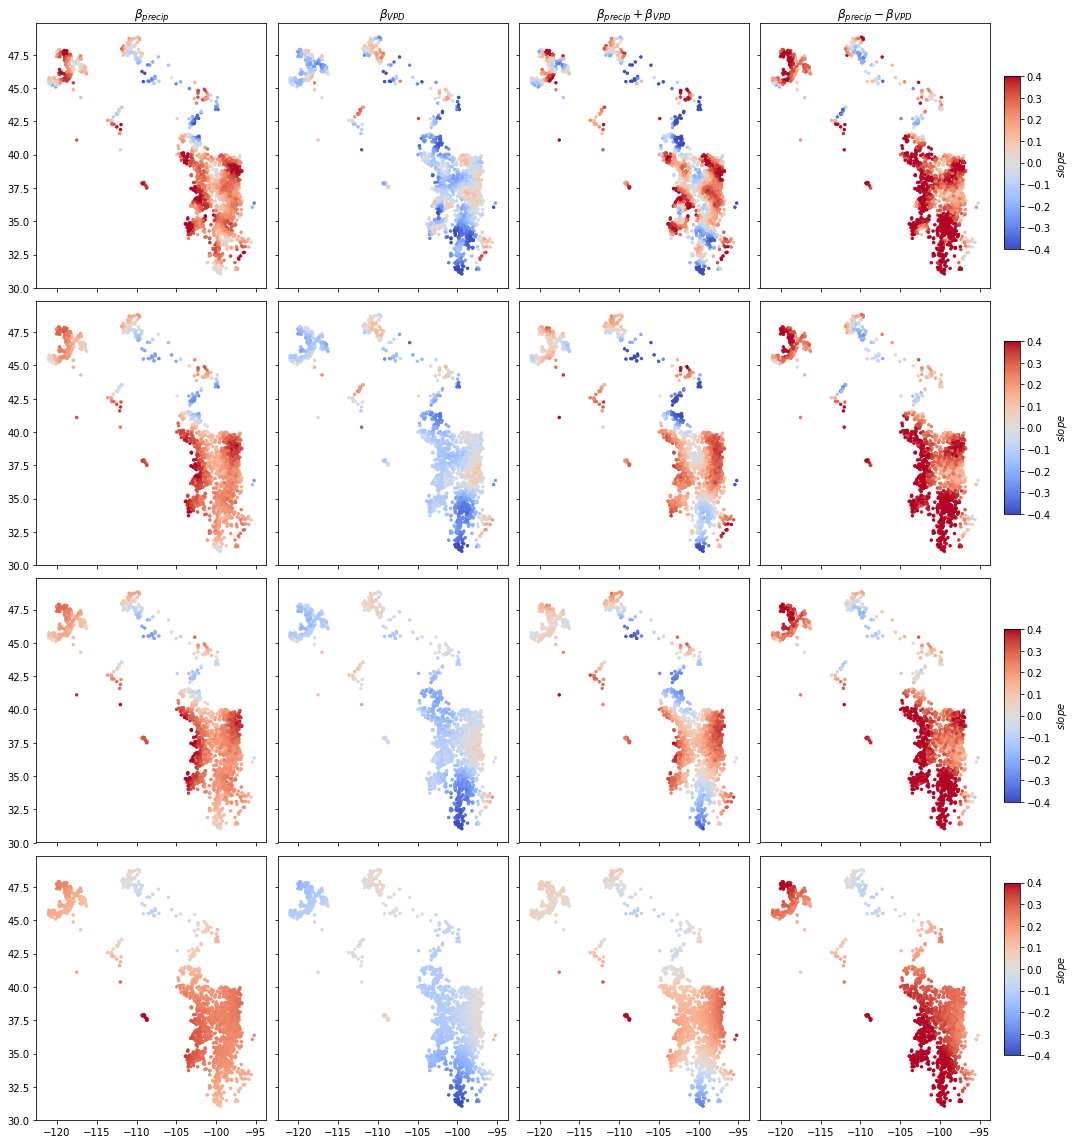

In [360]:
v = .4
fig, ax = plt.subplots(4,4, sharey=True, sharex=True, figsize=(14,16))

ax[0,0].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_prvpd3['w'].mean(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
ax[0,1].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_prvpd3['w1'].mean(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
ax[0,2].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_prvpd3['w'].mean(axis=0)+trace_prvpd3['w1'].mean(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
ax[0,3].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_prvpd3['w'].mean(axis=0)-trace_prvpd3['w1'].mean(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)

ax[1,0].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_prvpd2['w'].mean(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
ax[1,1].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_prvpd2['w1'].mean(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
ax[1,2].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_prvpd2['w'].mean(axis=0)+trace_prvpd2['w1'].mean(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
ax[1,3].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_prvpd2['w'].mean(axis=0)-trace_prvpd2['w1'].mean(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)

ax[2,0].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_prvpd['w'].mean(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
ax[2,1].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_prvpd['w1'].mean(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
ax[2,2].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_prvpd['w'].mean(axis=0)+trace_prvpd['w1'].mean(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
im = ax[2,3].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_prvpd['w'].mean(axis=0)-trace_prvpd['w1'].mean(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
ax[3,0].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_lsq['w'].mean(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
ax[3,1].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_lsq['w1'].mean(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
ax[3,2].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_lsq['w'].mean(axis=0)+trace_lsq['w1'].mean(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
ax[3,3].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_lsq['w'].mean(axis=0)-trace_lsq['w1'].mean(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)


cax1 = plt.axes([1, 0.08, 0.015, 0.15]) #[left, bottom, width, height]
cax2 = plt.axes([1, 0.3, 0.015, 0.15])
cax3 = plt.axes([1, 0.55, 0.015, 0.15])
cax4 = plt.axes([1, 0.78, 0.015, 0.15])
#cax = plt.axes([1, 0.12, 0.015, 0.75])
plt.colorbar(im,cax=cax1, label=r'$slope$')
plt.colorbar(im,cax=cax2,label=r'$slope$')
plt.colorbar(im,cax=cax3, label=r'$slope$')
plt.colorbar(im,cax=cax4, label=r'$slope$')

ax[0,0].set_title(r'$\beta_{precip}$')
ax[0,1].set_title(r'$\beta_{VPD}$')
ax[0,3].set_title(r'$\beta_{precip} -  \beta_{VPD}$')
ax[0,2].set_title(r'$\beta_{precip} + \beta_{VPD}$')
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.05, hspace=.05);

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


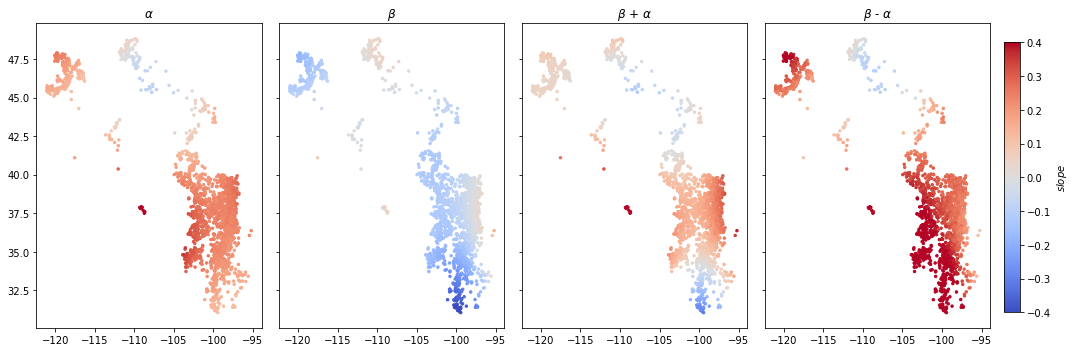

In [240]:
v = .4
fig, ax = plt.subplots(1,4, sharey=True, figsize=(14,5))
ax[0].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_lsq['w'].mean(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
ax[1].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_lsq['w1'].mean(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
ax[3].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_lsq['w'].mean(axis=0)-trace_lsq['w1'].mean(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
im = ax[2].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_lsq['w'].mean(axis=0)+trace_lsq['w1'].mean(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
#cax1 = plt.axes([1, 0.08, 0.015, 0.35]) #[left, bottom, width, height]
#cax2 = plt.axes([1, 0.58, 0.015, 0.35])
cax = plt.axes([1, 0.12, 0.015, 0.75])
plt.colorbar(im,cax=cax,label=r'$slope$')
#plt.colorbar(im,cax=cax2,label=r'$slope$')
ax[0].set_title(r'$\alpha$')
ax[1].set_title(r'$\beta$')
ax[3].set_title(r'$\beta$ - $\alpha$')
ax[2].set_title(r'$\beta$ + $\alpha$')
fig.tight_layout();

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


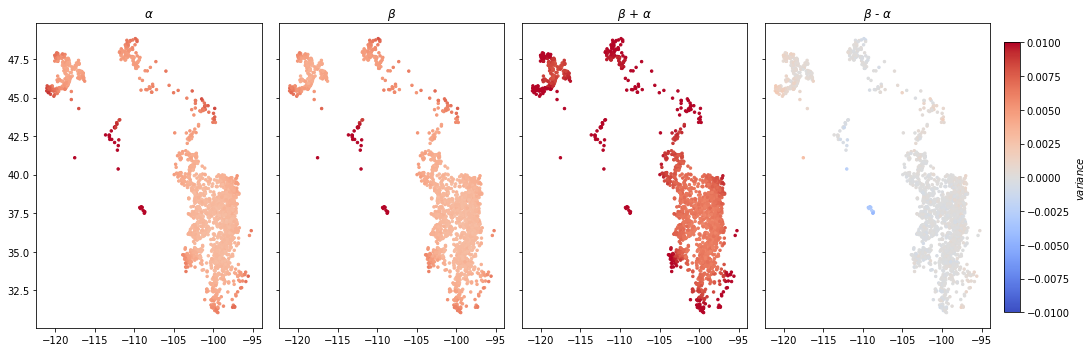

In [248]:
v = .01
fig, ax = plt.subplots(1,4, sharey=True, figsize=(14,5))
ax[0].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_lsq['w'].var(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
ax[1].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_lsq['w1'].var(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
ax[3].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_lsq['w'].var(axis=0)-trace_lsq['w1'].var(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
im = ax[2].scatter(df_unique.Longitude,df_unique.Latitude,c=trace_lsq['w'].var(axis=0)+trace_lsq['w1'].var(axis=0),
          cmap='coolwarm',vmax=v,vmin=-v,s=6)
#cax1 = plt.axes([1, 0.08, 0.015, 0.35]) #[left, bottom, width, height]
#cax2 = plt.axes([1, 0.58, 0.015, 0.35])
cax = plt.axes([1, 0.12, 0.015, 0.75])
plt.colorbar(im,cax=cax,label=r'$variance$')
#plt.colorbar(im,cax=cax2,label=r'$slope$')
ax[0].set_title(r'$\alpha$')
ax[1].set_title(r'$\beta$')
ax[3].set_title(r'$\beta$ - $\alpha$')
ax[2].set_title(r'$\beta$ + $\alpha$')
fig.tight_layout();

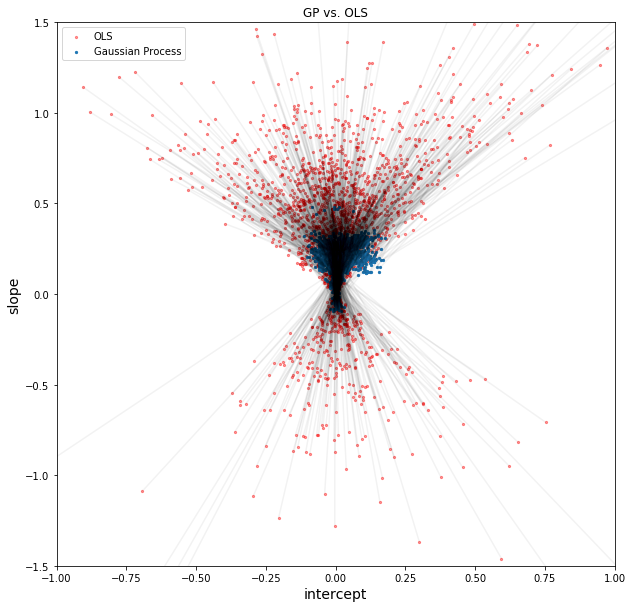

In [241]:
b1 = trace_lsq['w'].mean(axis=0)
a1 = trace_lsq['a'].mean(axis=0)

a2 = df_unique['a_zprsum3']
b2 = df_unique['B_zprsum3']

# plot both and connect with lines
_, ax = plt.subplots(1, 1, figsize=(10,10))
#ax.scatter(a0,b0,label='Ordinary Least Squares', s=10)
ax.scatter(a2, b2, label='OLS', c='r',s=5, alpha=.4)
ax.scatter(a1, b1, label='Gaussian Process', s=5, alpha=1)



#ax.plot([a1, a0], [b1, b0], 'k-', alpha=.05)
ax.plot([a1, a2], [b1, b2], 'k-', alpha=.05)
ax.set_xlabel('intercept', fontsize=14)
ax.set_ylabel('slope', fontsize=14)
ax.set_title('GP vs. OLS')
ax.set_xlim(-1,1)
ax.set_ylim(-1.5,1.5)
ax.legend();

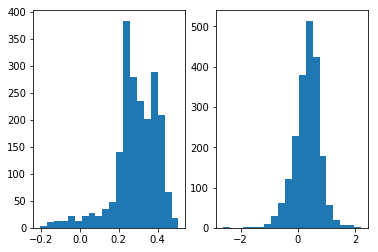

In [177]:
fig, ax = plt.subplots(1,2)
ax[0].hist(b1, 20)
ax[1].hist(b2, 20);

In [255]:
etasq = 1 # pm.Gamma('etasq', 5,10) # sets maximum covariance ij
lsq = 1e5 #pm.Gamma('lsq', alpha = 5, beta=7e-5)
#ls = pm.Deterministic('l', tt.sqrt(lsq))
sigmay = .01
Kij = etasq*(np.exp(-Dmatsq/lsq)+np.diag([sigmay]*Num_farms))

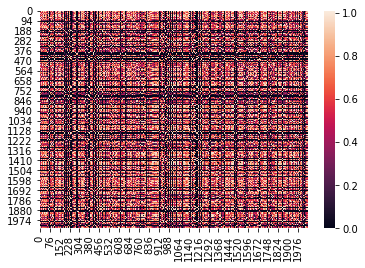

In [256]:
sns.heatmap(Kij);

In [142]:
df_unique['B_zprsum3'] = 0
df_unique['a_zprsum3'] = 0
column_x='zprsum3'
for i,p in enumerate(df_unique.index):
    mu,C = linear_pixel(df, p, column_x=column_x,column_y='zNDVIsum3', c=None,cluster=False)
    df_unique.loc[(df_unique.index == p),'B_' + column_x] = mu[1]
    df_unique.loc[(df_unique.index == p),'a_' + column_x] = mu[0]

In [144]:
import scipy
Kij_sparse = scipy.sparse.csr_matrix(Kij)

<98x98 sparse matrix of type '<class 'numpy.float64'>'
	with 9604 stored elements in Compressed Sparse Row format>

In [ ]:
trace_2000_prvpd

In [348]:
import pickle
datapath = '/home/brian/WesternWheat/Data/traces/'
with open(datapath + 'trace_2000_prvpd_24', 'wb') as outpickle:
    pickle.dump(trace_2000_prvpd, outpickle, protocol=pickle.HIGHEST_PROTOCOL)
    
